<a href="https://colab.research.google.com/github/mcleantom/MultiObjectiveOptimization/blob/main/GeneticAlgorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install osmnx ipyleaflet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.6 MB/s eta 0:00:00


RuntimeError: ignored

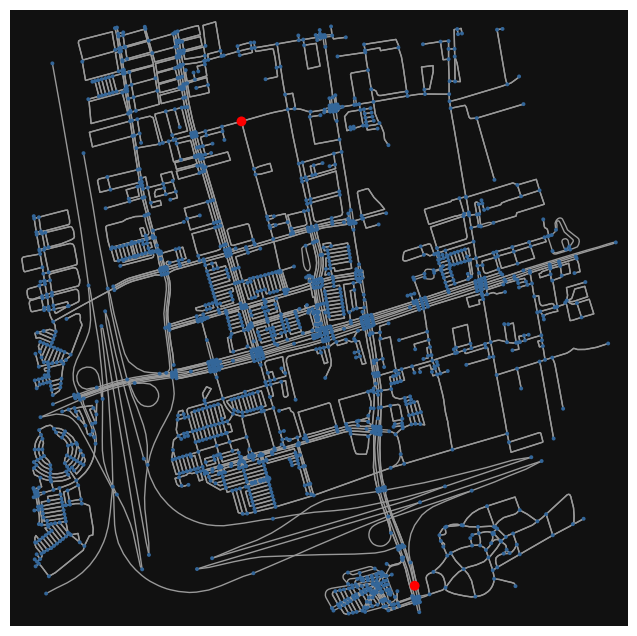

In [4]:
import osmnx

G = osmnx.graph_from_address('vaughan', dist=1400)

origin = 29658954
destination = 701446851

highlighted = [origin, destination]

nc = ['r' if node in highlighted else '#336699' for node in G.nodes()]
ns = [50 if node in highlighted else 8 for node in G.nodes()]
fig, ax = osmnx.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

In [9]:
"""
common stuff for gluing things together and hiding unnecessary complexity 
""" 
from collections import deque
import math
from copy import deepcopy
from itertools import islice
import itertools
import copy
from multiprocessing import Pool
import random
"""
This is a wrapper around osmnx nodes so we can query a single node
with questions like that without having to deal with networkx dictionaries:
    * how did we get here from the origin?
    * what are my children?
    * what is my unique id
"""

class Node:
    # using __slots__ for optimization
    __slots__ = ['node', 'distance', 'parent', 'osmid', 'G']
    # constructor for each node
    def __init__(self ,graph , osmid, distance = 0, parent = None):
        # the dictionary of each node as in networkx graph --- still needed for internal usage
        self.node = graph[osmid]
        
        # the distance from the parent node --- edge length
        self.distance = distance
        
        # the parent node
        self.parent = parent
        
        # unique identifier for each node so we don't use the dictionary returned from osmnx
        self.osmid = osmid
        
        # the graph
        self.G = graph
    
    # returning all the nodes adjacent to the node
    def expand(self):
        children = [Node(graph = self.G, osmid = child, distance = self.node[child][0]['length'], parent = self) \
                        for child in self.node]
        return children
    
    # returns the path from that node to the origin as a list and the length of that path
    def path(self):
        node = self
        path = []
        while node:
            path.append(node.osmid)
            node = node.parent
        return path[::-1]
    
    # the following two methods are for dictating how comparison works

    def __eq__(self, other):
        try:
            return self.osmid == other.osmid
        except:
            return self.osmid == other
            
    
    def __hash__(self):
        return hash(self.osmid)



def shortest_path_with_failed_nodes_single(G,route,failed:list):
    i = 1
    j = len(route) -2
    result = shortest_path_with_failed_nodes(G,route,i,j,failed)
    if result is math.inf: return result
    path, i,j, r = result
    return r

def shortest_path_with_failed_nodes(G, route ,i,j, failed : list):
    source = route[i-1]
    target = route[j+1]
    origin = Node(graph = G, osmid = source)
    destination = Node(graph = G, osmid = target)

    ## you can't introduce failure in the source and target
    # node, because your problem will lose its meaning
    if source in failed: failed.remove(source)
    if target in failed: failed.remove(target)
    
    # if after removing source/target node from failed
    # list - just return math.inf which is equivalent to failure in search
    if len(failed) == 0: return math.inf

    # we need to flag every node whether it is failed or not
    failure_nodes = {node: False for node in G.nodes()}
    failure_nodes.update({node: True for node in failed})

    # we need to make sure that while expansion we don't expand
    # any node from the original graph to avoid loops in our route
    tabu_list = route[:route.index(source)] \
                + \
                route[route.index(target) + 1:] 

    # the normal implementation of dijkstra
    shortest_dist = {node: math.inf for node in G.nodes()}
    unrelaxed_nodes = [Node(graph = G, osmid = node) for node in G.nodes()]
    seen = set()

    shortest_dist[source] = 0

    while len(unrelaxed_nodes) > 0:
        node = min(unrelaxed_nodes, key = lambda node : shortest_dist[node])

        # if we have relaxed articulation nodes in our graph
        # halt the process -- we have more than one component
        # in our graph which makes the question of shortest path
        # invalid

        if shortest_dist[node.osmid] == math.inf: return math.inf

        if node == destination:
            return node.path(),i,j, route

        unrelaxed_nodes.remove(node); seen.add(node.osmid) # relaxing the node

        for child in node.expand():
            # if it is failed node, skip it
            if failure_nodes[child.osmid] or\
                child.osmid in seen or\
                child.osmid in tabu_list:
                continue

            child_obj = next((node for node in unrelaxed_nodes if node.osmid == child.osmid), None)
            child_obj.distance = child.distance

            distance = shortest_dist[node.osmid] + child.distance
            if distance < shortest_dist[child_obj.osmid]:
                shortest_dist[child_obj.osmid] = distance
                child_obj.parent = node

    # in case the node can't be reached from the origin
    # this return happens when the node is not on the graph
    # at all, if it was on a different component the second
    # return will be executed -- this is the third return
    
    return math.inf


def shortest_path_handler(args):
    return shortest_path_with_failed_nodes(*args)


def children_route(G, route, limit):
    results = []
    for i in range(1, len(route) - 1):
        for j in range(i, len(route) -1):
            # we can't work on the route list directly
            # because lists are passed by reference
            stitched = copy.deepcopy(route)
            failing_nodes = copy.deepcopy(route[i:j+1])
            args = shortest_path_with_failed_nodes(G, stitched, i,j, failing_nodes)
            if args == math.inf: continue
            to_be_stitched, k, l, r = args
            stitched[i:j+1] = to_be_stitched[1:-1]      # we need to skip the first and starting nodes of this route
                                                        # because these nodes already exit
            results.append(stitched)
            if len(results) == limit: return results
    return results

def children_route_handler(args):
    return children_route(*args)


def get_children(G, route, num_children=20, multiprocessing=False, workers=4):
    if multiprocessing:
        worker = ChildRoutesGenerator(workers=workers,G = G, route=route, limit=num_children)
        worker.do_job()
        worker.pool.terminate()
        worker.pool.join()
        return worker.result
    return children_route(G,route,num_children)


class ChildRoutesGenerator():
    def __init__(self, workers, G, route, limit=20):
        self.workers = workers
        self.pool = Pool(processes=self.workers)
        self.result = []
        self.limit = limit
        self.G = G
        self.route = route

    def do_beam(self,routes):
        args = []
        results = []
        for r in routes:
            args.append((self.G,r,self.limit))
        for _ in self.pool.imap_unordered(children_route_handler,args, chunksize=1):
            results.append(_)
        self.pool.terminate()
        self.pool.join()
        return results

    def do_job(self, route=None, refresh=False):
        
        if refresh: self.pool = Pool(processes=self.workers)
        if route is not None:
            self.route = route
        args = []
        
        for i in range(1, len(self.route) - 1):
            for j in range(i, len(self.route) -1):
                stitched = deepcopy(self.route)
                failing_nodes = deepcopy(self.route[i:j+1])
                args.append((self.G, stitched, i, j, failing_nodes))
        
        for _ in self.pool.imap_unordered(shortest_path_handler,args, chunksize=1):
            if _ == math.inf: 
                continue
            new,i,j,old = _
            old[i:j+1] = new[1:-1]
            self.result.append(old)
            if len(self.result) == self.limit:
                break
        self.pool.terminate()
        self.pool.join()
        return self.result

def randomized_search(G, source, destination):
    origin = Node(graph = G, osmid = source)
    destination = Node(graph = G, osmid = destination)
    
    route = [] # the route to be yielded
    frontier = deque([origin])
    explored = set()
    while frontier:
        node = random.choice(frontier)   # here is the randomization part
        frontier.remove(node)
        explored.add(node.osmid)

        for child in node.expand():
            if child not in explored and child not in frontier:
                if child == destination:
                    route = child.path()
                    return route
                frontier.append(child)

    raise Exception("destination and source are not on same component")

def probability(p):
    return p > random.uniform(0.0, 1.0)

def flatten(list2d):
    return list(itertools.chain(*list2d))

def cost(G, route):
    weight = 0
    for u, v in zip(route, route[1:]):
        weight += G[u][v][0]['length']   
    return round(weight,4)

In [7]:
def mutate(G, route):
  """
  Mutate a child route by deleting a node between two nodes and fill in the gap
  with a alternate nodes
  """
  source = route[0]
  destination = route[-1]

  failed = random.choice(route)

  path = shortest_path_with_failed_nodes_single(G, route, [failed])

  while path == math.inf:
    failed = random.choice(route)
    path = shortest_path_with_failed_nodes_single(G, route, [failed])
  
  return path


def cross_over(route_1, route_2):
  """
  Rather than finding a random point, look for a common node between two routes
  """
  origin = route_1[0]
  desination = route_1[-1]

  intersection = [*itertools.filterfalse(\
                  lambda element : element in [origin, destination] ,\
                  list(set(route_1) & set(route_2)))]
  
  if len(intersection) == 0:
    return route_1
  
  cross_over_point = random.choice(intersection)
  first_point = route_1.index(cross_over_point)
  second_point = route_2.index(cross_over_point)

  if probability(0.50):
      return route_1[:first_point] + route_2[second_point:]
  else:
      return route_2[:second_point] + route_1[first_point:]


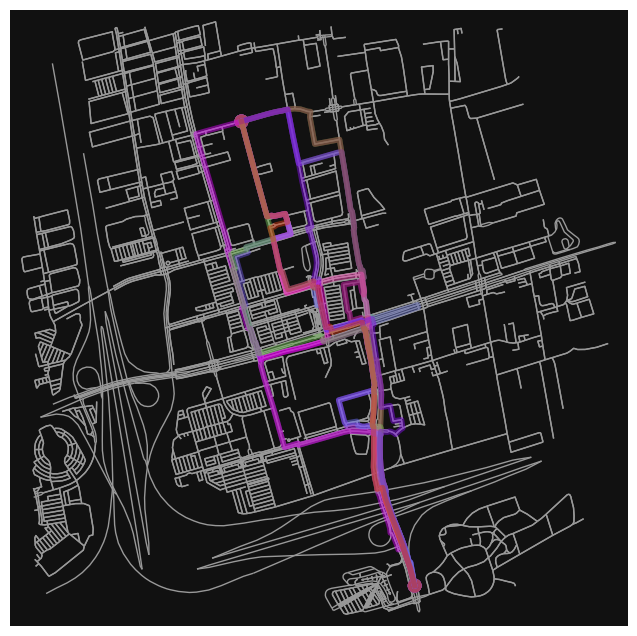

In [10]:
n_gen = 100
pool_size = 12
parents_num = 4

pool = [randomized_search(G, origin, destination) for _ in range(pool_size)]

random_hexa = lambda: random.randint(0, 255)  # random hex color
rc = ['#%02X%02X%02X' % (random_hexa(),random_hexa(),random_hexa()) for _ in range(pool_size)]
fig, ax = osmnx.plot_graph_routes(G, pool, route_colors=rc, route_linewidth=6, node_size=0)


In [11]:
from tqdm.notebook import tqdm
import heapq

states = []

def select_best(pool, num_of_choices, probability_dist):
        return random.choices(population=pool, weights=probability_dist, k= num_of_choices)


for gen in tqdm(range(n_gen)):
  weights = [cost(G, route) for route in pool]
  parents_1 = select_best(pool, parents_num, weights)
  parents_2 = [cross_over(route_1, route_2) for route_1, route_2 in itertools.combinations(parents_1, r=2)]
  pool.extend([mutate(G, route) for route in parents_2])
  pool = [*map(list, list(set(map(tuple, pool))))]
  num_removed = pool_size - len(pool) + 1
  pool.extend([randomized_search(G, origin, destination) for _ in range(num_removed)])
  pool = heapq.nsmallest(pool_size, pool, key=lambda x: cost(G, x))
  m = cost(G, min(pool, key = lambda route: cost(G, route)))
  states.append(m)

route = min(pool, key=lambda route: cost(G, route))


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of the route: 2714.749


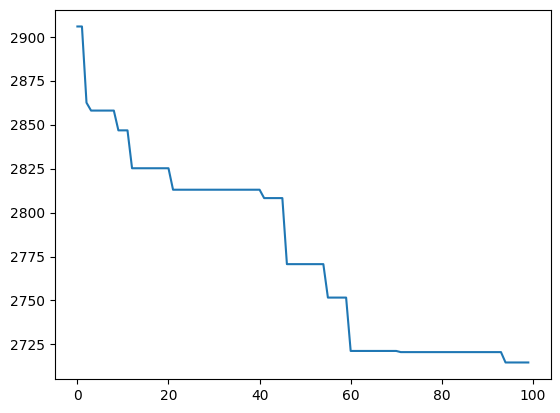

In [13]:
import matplotlib.pyplot as plt
print("Cost of the route:",cost(G,route))
ax = plt.plot(states)

In [16]:
import pandas, numpy
import ipyleaflet as lf
import folium as fl
import osmnx as ox
import networkx as nx


def get_center(G):
    undir = G.to_undirected()
    length_func = nx.single_source_dijkstra_path_length
    sp = {source: dict(length_func(undir, source, weight="length")) for source in G.nodes}
    eccentricity = nx.eccentricity(undir,sp=sp)
    center_osmid = nx.center(undir,e=eccentricity)[0]
    return center_osmid



def draw_route(G, route, zoom = 15, force_leaflet=False):
    
    center_osmid = get_center(G)
    G_gdfs = ox.graph_to_gdfs(G)
    nodes_frame = G_gdfs[0]
    ways_frame = G_gdfs[1]
    center_node = nodes_frame.loc[center_osmid]
    location = (center_node['y'], center_node['x'])
    

    start_node = nodes_frame.loc[route[0]]
    end_node = nodes_frame.loc[route[len(route)-1]]

    start_xy = (start_node['y'], start_node['x'])
    end_xy = (end_node['y'], end_node['x'])
    

    if len(route) >= 500 and not force_leaflet:
        print(f"The route has {len(G)} elements, using folium to improve performance.")
        m = ox.plot_route_folium(G = G, route = route, zoom= zoom, color='red')
        fl.Marker(location=start_xy).add_to(m)
        fl.Marker(location=end_xy).add_to(m)
        return m

    m = lf.Map(center = location, zoom = zoom)
    marker = lf.Marker(location = start_xy, draggable = False)
    m.add_layer(marker)
    marker = lf.Marker(location = end_xy, draggable = False)
    m.add_layer(marker)

    for u, v in zip(route[0:], route[1:]):
        try:
            geo = (ways_frame.query(f'u == {u} and v == {v}').to_dict('list')['geometry'])
            m_geo = min(geo,key=lambda x:x.length)
        except:
            geo = (ways_frame.query(f'u == {v} and v == {u}').to_dict('list')['geometry'])
            m_geo = min(geo,key=lambda x:x.length)
        x, y = m_geo.coords.xy
        points = map(list, [*zip([*y],[*x])])
        ant_path = lf.AntPath(
            locations = [*points], 
            dash_array=[1, 10],
            delay=1000,
            color='red',
            pulse_color='black'
        )
        m.add_layer(ant_path)

    return m

In [17]:
draw_route(G,route, zoom=13)

Map(center=[43.7907708, -79.5414667], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…